# Basic Power Flow Analysis and OPF

See Section 10.1 of 000421

In [1]:
import numpy as np
import networkx as nx
import pandas as pd

## Network creation

In [2]:
# Create graph
G = nx.DiGraph()

# Nodes with max set point and complex demand
G.add_node(0,name='slack',smax=10,d=0)
G.add_node(1,name='step',smax=0,d=0)
G.add_node(2,name='house',smax=0,d=1.2+0.3j)
G.add_node(3,name='solar',smax=1,d=0)
G.add_node(4,name='building',smax=0,d=2.5+0.9j)
G.add_node(5,name='wind',smax=1.5,d=0)

# Edges with admittance
G.add_edge(0,1,y=1/(0.0075+0.010j),thlim=2)
G.add_edge(1,2,y=1/(0.0080+0.011j),thlim=2)
G.add_edge(2,3,y=1/(0.0090+0.018j),thlim=2)
G.add_edge(1,4,y=1/(0.0040+0.004j),thlim=2)
G.add_edge(4,5,y=1/(0.0050+0.006j),thlim=2)

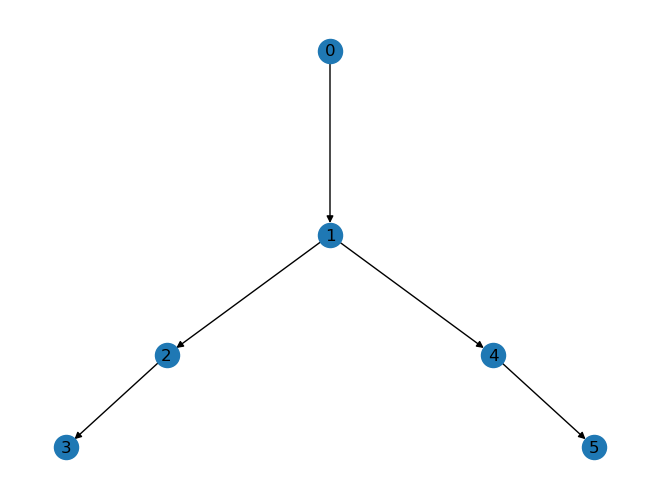

In [3]:
nx.draw(G,with_labels=True,pos=nx.spectral_layout(G))

## Fixed Point Algorithm

### Admittance matrix

In [4]:
A = nx.incidence_matrix(G, oriented=True)
Yp = np.diag([G.edges[k]["y"] for k in G.edges])
Ybus = A @ Yp @ A.T

In [5]:
# Admittances on edges?
print(Yp)
print(Yp.shape)

[[ 48.         -64.j           0.          +0.j
    0.          +0.j           0.          +0.j
    0.          +0.j        ]
 [  0.          +0.j          43.24324324 -59.45945946j
    0.          +0.j           0.          +0.j
    0.          +0.j        ]
 [  0.          +0.j           0.          +0.j
  125.        -125.j           0.          +0.j
    0.          +0.j        ]
 [  0.          +0.j           0.          +0.j
    0.          +0.j          22.22222222 -44.44444444j
    0.          +0.j        ]
 [  0.          +0.j           0.          +0.j
    0.          +0.j           0.          +0.j
   81.96721311 -98.36065574j]]
(5, 5)


In [6]:
print(A)
print(A.shape)

  (0, 0)	-1.0
  (1, 0)	1.0
  (1, 1)	-1.0
  (2, 1)	1.0
  (1, 2)	-1.0
  (4, 2)	1.0
  (2, 3)	-1.0
  (3, 3)	1.0
  (4, 4)	-1.0
  (5, 4)	1.0
(6, 5)


In [7]:
print(Ybus)

[[  48.         -64.j          -48.         +64.j
     0.          +0.j            0.          +0.j
     0.          +0.j            0.          +0.j        ]
 [ -48.         +64.j          216.24324324-248.45945946j
   -43.24324324 +59.45945946j    0.          +0.j
  -125.        +125.j            0.          +0.j        ]
 [   0.          +0.j          -43.24324324 +59.45945946j
    65.46546547-103.9039039j   -22.22222222 +44.44444444j
     0.          +0.j            0.          +0.j        ]
 [   0.          +0.j            0.          +0.j
   -22.22222222 +44.44444444j   22.22222222 -44.44444444j
     0.          +0.j            0.          +0.j        ]
 [   0.          +0.j         -125.        +125.j
     0.          +0.j            0.          +0.j
   206.96721311-223.36065574j  -81.96721311 +98.36065574j]
 [   0.          +0.j            0.          +0.j
     0.          +0.j            0.          +0.j
   -81.96721311 +98.36065574j   81.96721311 -98.36065574j]]


In [8]:
# positive semidefinite if has non-negative eigenvalues?
# Confirm this
print(np.linalg.eigvals(Ybus.real))

[3.55850779e+02 1.53742122e+02 6.95171530e+01 4.52945499e+01
 1.13763515e-14 1.64607529e+01]


### Block matrices

In [9]:
n = G.number_of_nodes()
YN0 = Ybus[1:n,0]
YNN = Ybus[1:n,1:n]
ZNN = np.linalg.inv(YNN)
d = np.array([G.nodes[k]['d'] for k in G.nodes])
print(YN0)
print(YNN)
print(d)

[-48.+64.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j]
[[ 216.24324324-248.45945946j  -43.24324324 +59.45945946j
     0.          +0.j         -125.        +125.j
     0.          +0.j        ]
 [ -43.24324324 +59.45945946j   65.46546547-103.9039039j
   -22.22222222 +44.44444444j    0.          +0.j
     0.          +0.j        ]
 [   0.          +0.j          -22.22222222 +44.44444444j
    22.22222222 -44.44444444j    0.          +0.j
     0.          +0.j        ]
 [-125.        +125.j            0.          +0.j
     0.          +0.j          206.96721311-223.36065574j
   -81.96721311 +98.36065574j]
 [   0.          +0.j            0.          +0.j
     0.          +0.j          -81.96721311 +98.36065574j
    81.96721311 -98.36065574j]]
[0. +0.j  0. +0.j  1.2+0.3j 0. +0.j  2.5+0.9j 0. +0.j ]


In [10]:
def fixed_point(sN, dN):
    v0 = 1+0j
    vN = np.ones(n-1)*(1+0j)
    for t in range(10):
        vN = ZNN@(np.conj((sN-dN)/vN)-v0*YN0)
        vT = np.hstack([v0,vN]);
        sT = vT*np.conj(Ybus@vT)
        err = np.linalg.norm(sT[1:n]-(sN-dN))
    print('Load Flow, after 10 iterations the error is',err)
    return vT

In [11]:
VT = fixed_point(np.zeros(n-1), d[1:n])
ST = VT*np.conj(Ybus@VT)
pL = sum(ST)
print('Loss',pL)
for (k,m) in G.edges:
    Sf = Ybus[k,m]*(VT[k]-VT[m])
    print('flow',(k,m),np.abs(Sf))

Load Flow, after 10 iterations the error is 9.83303826452342e-12
Loss (0.17318313352728584+0.22089148762914415j)
flow (0, 1) 4.125588467764213
flow (1, 2) 1.311125926883093
flow (1, 4) 2.818560023222717
flow (2, 3) 0.0
flow (4, 5) 3.553737302566694e-14


In [12]:
results = pd.DataFrame()
results['name'] = [G.nodes[k]['name'] for k in G.nodes]
results['vpu'] = np.abs(VT)
results['ang'] = np.angle(VT)*180/np.pi
results['pnode'] = np.round(ST.real,4)
results['qnode'] = np.round(ST.imag,4)
results

,name,vpu,ang,pnode,qnode
0,slack,1.000000,0.000000,3.8732,1.4209
1,step,0.957154,-1.680835,-0.0000,0.0000
2,house,0.943412,-2.366124,-1.2000,-0.3000
3,solar,0.943412,-2.366124,0.0000,-0.0000
4,building,0.942703,-2.087231,-2.5000,-0.9000
5,wind,0.942703,-2.087231,-0.0000,-0.0000


## Symbolic

In [115]:
import sympy as sp
from scipy import optimize as opt
import numpy.linalg as la

In [116]:
def newton_raphson(f, df, x0, verbose=False, niter=10):
    y = x0

    fval = f(*y)
    if verbose:
        print(f'Iteration {0}: norm: {la.norm(fval)}')
        
    for i in range(niter):
        inc = (la.inv(df(*y)) @ fval).reshape(-1)
        y = y - inc
        fval = f(*y)
        if verbose:
            print(f'Iteration {i+1}: norm: {la.norm(fval)}')

    return y

In [117]:
Gbus = np.real(Ybus)
Bbus = np.imag(Ybus)

In [118]:
n = Ybus.shape[0] # 6

In [119]:
P = []
Q = []
V = []
theta = []

for i in range(n):
    P.append(sp.Symbol('P'+str(i)))
    Q.append(sp.Symbol('Q'+str(i)))
    V.append(sp.Symbol('V'+str(i)))
    theta.append(sp.Symbol('theta'+str(i)))

B = []
G = []
for i in range(n):
    B.append([])
    G.append([])
    for j in range(n):
        B[i].append(sp.Symbol('B'+str(i)+str(j)))
        G[i].append(sp.Symbol('G'+str(i)+str(j)))

In [120]:
# Including Slack bus
# x = [P[0], Q[0]] + theta[1:] + V[1:]

# Basic power flow equations
x = theta[1:] + V[1:]
x


[theta1, theta2, theta3, theta4, theta5, V1, V2, V3, V4, V5]

In [121]:
param = [V[0], theta[0]] + P[1:] + Q[1:]
param_values = [1, 0, ] + (-np.real(d[1:])).tolist() + (-np.imag(d[1:])).tolist()
param, param_values

([V0, theta0, P1, P2, P3, P4, P5, Q1, Q2, Q3, Q4, Q5],
 [1, 0, -0.0, -1.2, -0.0, -2.5, -0.0, -0.0, -0.3, -0.0, -0.9, -0.0])

In [122]:
def p_k(k):
    return sum([V[k] * V[j] * (G[k][j] * sp.cos(theta[k] - theta[j]) + B[k][j] * sp.sin(theta[k] - theta[j])) for j in range(n)])

def q_k(k):
    return sum([V[k] * V[j] * (G[k][j] * sp.sin(theta[k] - theta[j]) - B[k][j] * sp.cos(theta[k] - theta[j])) for j in range(n)])

# Basic power flow equations
# f = sp.Matrix([p_k(i) - P[i]  for i in range(1, n)] + [q_k(i) - Q[i]  for i in range(1, n)])
# g = P[1:] + Q[1:]

# With slack bus
f = sp.Matrix([p_k(i) - P[i]  for i in range(n)] + [q_k(i) - Q[i]  for i in range(n)])
g = P + Q


p = sp.Matrix([p_k(i) for i in range(n)])
q = sp.Matrix([q_k(i) for i in range(n)])

In [127]:
p_k(0)

G00*V0**2 + V0*V1*(B01*sin(theta0 - theta1) + G01*cos(theta0 - theta1)) + V0*V2*(B02*sin(theta0 - theta2) + G02*cos(theta0 - theta2)) + V0*V3*(B03*sin(theta0 - theta3) + G03*cos(theta0 - theta3)) + V0*V4*(B04*sin(theta0 - theta4) + G04*cos(theta0 - theta4)) + V0*V5*(B05*sin(theta0 - theta5) + G05*cos(theta0 - theta5))

In [126]:
sp.diff(p_k(0), P[1])

0

In [96]:
f = f.subs(zip(param, param_values))
f = f.subs(zip([B[i][j] for i in range(n) for j in range(n)], [Bbus[i, j] for i in range(n) for j in range(n)]))
f = f.subs(zip([G[i][j] for i in range(n) for j in range(n)], [Gbus[i, j] for i in range(n) for j in range(n)]))

p = p.subs(zip(param, param_values))
p = p.subs(zip([B[i][j] for i in range(n) for j in range(n)], [Bbus[i, j] for i in range(n) for j in range(n)]))
p = p.subs(zip([G[i][j] for i in range(n) for j in range(n)], [Gbus[i, j] for i in range(n) for j in range(n)]))

q = q.subs(zip(param, param_values))
q = q.subs(zip([B[i][j] for i in range(n) for j in range(n)], [Bbus[i, j] for i in range(n) for j in range(n)]))
q = q.subs(zip([G[i][j] for i in range(n) for j in range(n)], [Gbus[i, j] for i in range(n) for j in range(n)]))

In [97]:
f

Matrix([
[                                                                                                                                                                        -P0 + V1*(-64.0*sin(theta1) - 48.0*cos(theta1)) + 48.0],
[   216.243243243243*V1**2 + V1*V2*(59.4594594594595*sin(theta1 - theta2) - 43.2432432432432*cos(theta1 - theta2)) + V1*V4*(125.0*sin(theta1 - theta4) - 125.0*cos(theta1 - theta4)) + V1*(64.0*sin(theta1) - 48.0*cos(theta1))],
[                 V1*V2*(-59.4594594594595*sin(theta1 - theta2) - 43.2432432432432*cos(theta1 - theta2)) + 65.4654654654655*V2**2 + V2*V3*(44.4444444444444*sin(theta2 - theta3) - 22.2222222222222*cos(theta2 - theta3)) + 1.2],
[                                                                                                               V2*V3*(-44.4444444444444*sin(theta2 - theta3) - 22.2222222222222*cos(theta2 - theta3)) + 22.2222222222222*V3**2],
[                                       V1*V4*(-125.0*sin(theta1 - theta4) - 125.0*cos(

In [98]:
# These are alighned with the expresssions from 4.46 and 4.47 in 000505
df = f.jacobian(x)

In [99]:
df

Matrix([
[-1,  0,                                                                                                                                                           V1*(48.0*sin(theta1) - 64.0*cos(theta1)),                                                                                                                                                                              0,                                                                                      0,                                                                                                                                                        0,                                                                                      0,                                                                                                                                                                            -64.0*sin(theta1) - 48.0*cos(theta1),                                                                        

In [100]:
dfcall = sp.lambdify(x, df, 'numpy')
fcall = sp.lambdify(x, f, 'numpy')

p0call = sp.lambdify(x, p_k(0), 'numpy')
q0call = sp.lambdify(x, q_k(0), 'numpy')

pcall = sp.lambdify(x, p, 'numpy') 
qcall = sp.lambdify(x, q, 'numpy') 

In [101]:
f.shape

(12, 1)

In [105]:
# Basic power flow equations
# x0 = np.array([0]*(n-1) + [1] * (n-1))

# With slack bus
x0 = np.array([0]*(n) + [1] * (n))

In [106]:
y = newton_raphson(fcall, dfcall, x0, verbose=True, niter=10)

Iteration 0: norm: 173.58802998018027
Iteration 1: norm: 35.21926627916808
Iteration 2: norm: 6.467067279039918
Iteration 3: norm: 1.0288578553764385
Iteration 4: norm: 0.08308278866360941
Iteration 5: norm: 0.000518750223617371
Iteration 6: norm: 4.76958805051579e-08
Iteration 7: norm: 5.483320576654713e-15
Iteration 8: norm: 5.4832542844389425e-15
Iteration 9: norm: 8.230078114581984e-15
Iteration 10: norm: 1.4957654554761465e-14


In [107]:
y

array([ 2.88552010e+01,  3.19387243e+01, -1.05193439e-01, -1.58215588e-01,
       -1.58215588e-01, -1.29415094e-01,  6.67728209e+00,  4.66778977e-01,
        4.36574789e-01,  4.36574789e-01,  2.37883241e-01, -1.36845553e-48])

In [108]:
y_fixed = np.concatenate((np.angle(VT)[1:], np.abs(VT)[1:]), axis=0)
y_fixed

array([-0.02933611, -0.04129665, -0.04129665, -0.03642905, -0.03642905,
        0.95715405,  0.94341181,  0.94341181,  0.94270338,  0.94270338])

In [109]:
fcall(*y)

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 6.66133815e-16],
       [ 0.00000000e+00],
       [-1.77635684e-15],
       [ 7.10192553e-48],
       [-1.42108547e-14],
       [ 3.55271368e-15],
       [ 1.05471187e-15],
       [ 0.00000000e+00],
       [-2.10942375e-15],
       [ 4.10706747e-47]])

In [110]:
fcall(*y_fixed)

TypeError: _lambdifygenerated() missing 2 required positional arguments: 'V4' and 'V5'

In [75]:
VT*np.conj(Ybus@VT)

array([ 3.87318313e+00+1.42089149e+00j, -1.23992091e-14+4.11873455e-14j,
       -1.20000000e+00-3.00000000e-01j,  0.00000000e+00-0.00000000e+00j,
       -2.50000000e+00-9.00000000e-01j, -1.46375481e-15-4.01631976e-14j])

In [76]:
pcall(*y)

array([[ 3.87318313e+00],
       [-7.10542736e-15],
       [-1.20000000e+00],
       [ 0.00000000e+00],
       [-2.50000000e+00],
       [ 0.00000000e+00]])

In [79]:
qcall(*y)

array([[ 1.42089149e+00],
       [-7.10542736e-15],
       [-3.00000000e-01],
       [ 0.00000000e+00],
       [-9.00000000e-01],
       [ 0.00000000e+00]])

In [78]:
pcall(*y_fixed)

array([[ 3.87318313e+00],
       [-1.63424829e-13],
       [-1.20000000e+00],
       [ 0.00000000e+00],
       [-2.50000000e+00],
       [ 0.00000000e+00]])

In [80]:
results_nr = pd.DataFrame()
results_nr['name'] = [G.nodes[k]['name'] for k in G.nodes]
results_nr['vpu'] = [1] + y[5:]
results_nr['ang'] = [0] + y[:5]
results_nr['pnode'] = [p0call(y)] 
results_nr['qnode'] = np.round(ST.imag,4)
results_nr

AttributeError: 'list' object has no attribute 'nodes'